## Import

In [1481]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [1482]:
class CFG:
    SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [1483]:
# Our dataset has identical columns : 'id', 'father', 'mother', 'gender'
train = pd.read_csv('./train.csv')
train = train.drop(['id','father', 'mother', 'gender'], axis= 1)
test = pd.read_csv('./test.csv')
test = test.drop(['id', 'father', 'mother', 'gender'], axis= 1)

In [1484]:
train['class'].value_counts()

B    114
C     79
A     69
Name: class, dtype: int64

### If "trait" column is 1, then our class is "A" definitely  
- make new column. 

In [1485]:
train[train['trait']==1]['class'].value_counts()

A    69
Name: class, dtype: int64

In [1486]:
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['class'])
        df_y = df['class']
        return df_x, df_y
    else:
        # df_x = df.drop(columns=['id']) # already remove them
        return df

In [1487]:
train['trait_is_1_and_class_A'] = (train['trait'] == 1) & (train['class'] == "A")
test['trait_is_1_and_class_A'] = (test['trait'] == 1)
test.head()

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,trait_is_1_and_class_A
0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A,True
1,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A,False
2,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G,False
3,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A,False
4,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G,True


In [1488]:
train_x, train_y = get_x_y(train) 
test_x = get_x_y(test)

### DNA sequencing has 4 type bases. A(Adenine), G(Guanine), C(Cytosine), T(Thymine)
- bases are a combination with complementary DNA. for example A combined with T. In other case G combined with C
- So replace G -> C, T -> A. but our dataset doesn't have T(Thymine)

In [1489]:

train_x = train_x.replace('A G', 'A C')
test_x = test_x.replace('A G', 'A C')

train_x = train_x.replace('G G', 'C C')
test_x = test_x.replace('G G', 'C C')

train_x = train_x.replace('G A', 'A C')
test_x = test_x.replace('G A', 'A C')

In [1491]:
train['class'].value_counts()

B    114
C     79
A     69
Name: class, dtype: int64

In [1492]:
train_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,...,SNP_13,SNP_14,SNP_15,trait_is_1_and_class_A,SNP_line2,SNP_line6,SNP_line7,SNP_line8,SNP_line9,SNP_line10
0,2,C C,A C,A A,A C,C A,A A,A A,C C,A A,...,A A,A A,A A,False,0,0,0,1,0,0
1,2,A C,A C,C A,A A,A A,A C,A A,A C,A A,...,C C,A A,A A,False,1,0,1,0,0,0
2,2,C C,C C,A A,A C,C C,C C,A A,A C,A C,...,A A,A A,A A,False,0,1,1,0,0,0
3,1,A A,C C,A A,A C,A A,C C,C C,A A,C C,...,C C,A A,C C,True,0,0,1,0,0,0
4,2,C C,C C,C C,A A,C C,A A,A A,A A,A A,...,A C,A A,A C,False,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,A C,A C,A A,A C,C C,A C,A A,A C,A A,...,A A,A A,A A,False,1,0,0,1,0,0
258,2,C C,A A,C A,A A,A A,A C,A C,A C,A A,...,A C,A A,A C,False,0,0,1,1,0,1
259,1,A C,C C,A A,A C,A A,A C,C C,A C,A C,...,C C,C A,C C,True,1,1,0,0,1,0
260,1,A A,C C,A A,A C,A A,C C,C C,A A,A C,...,C C,C A,C C,True,0,1,1,1,1,0


In [1494]:
t_x, v_x, t_y, v_y = train_test_split(train_x, train_y, train_size = 0.9)
t_y.head()

68     B
90     B
15     A
30     B
193    B
Name: class, dtype: object

## LabelEncoder 

In [1495]:
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])

#### We apply SMOTE, a data oversampling technique, to resolve the class imbalance problem in our dataset.

In [1496]:
sm = SMOTE(random_state=42)

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(train_x, train_y)

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

In [1497]:
train = pd.concat([train_x, pd.DataFrame({'class':train_y})], axis=1)
t = train.drop(train[train['trait_is_1_and_class_A'] == True].index)
train = pd.concat([X_resampled, pd.DataFrame({'class':y_resampled})], axis=1)

In [1498]:
train = pd.concat([train_x, pd.DataFrame({'class':train_y})], axis=1)
t = train.drop(train[train['trait_is_1_and_class_A'] == True].index)
t = t.drop(['trait', 'trait_is_1_and_class_A'], axis=1)

# Correlation Matrix 

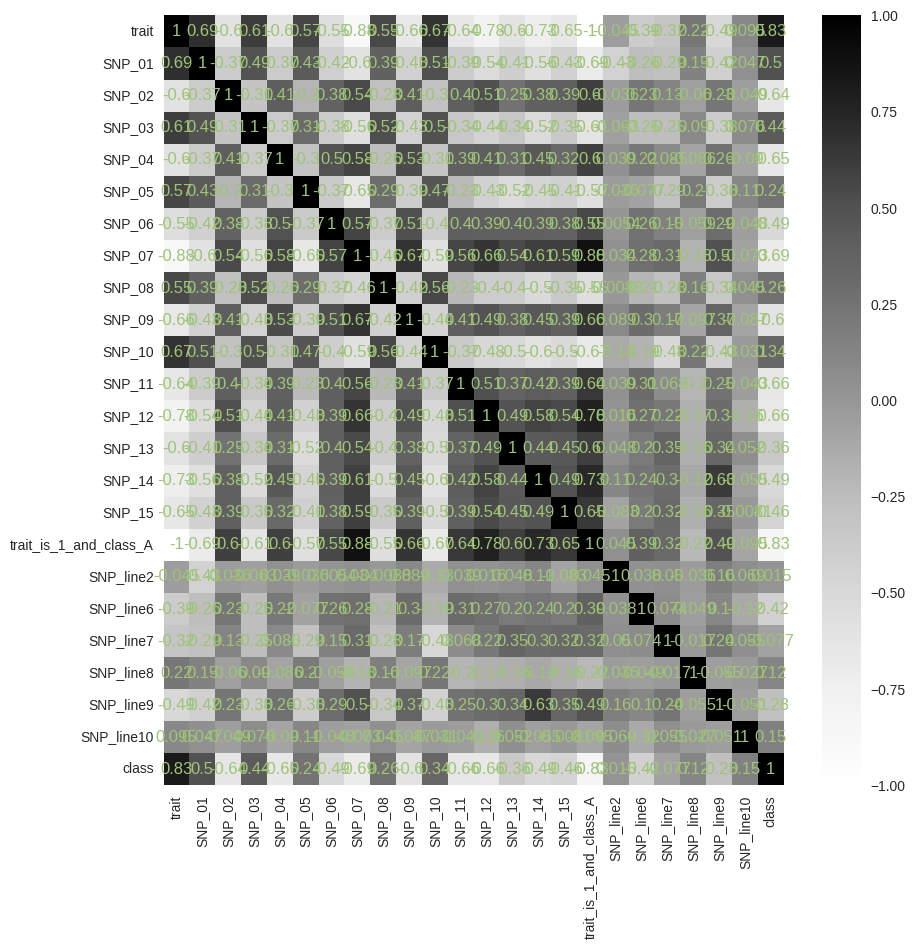

In [1499]:
plt.figure(figsize = (10,10))
train = pd.concat([train_x, pd.DataFrame({'class':train_y})], axis=1)
# train_c = train[train['class'] == 2]
ax = sns.heatmap(train.corr(), annot=True, annot_kws=dict(color='g'), cmap='Greys')
plt.show()

In [1500]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   trait                   262 non-null    int64
 1   SNP_01                  262 non-null    int64
 2   SNP_02                  262 non-null    int64
 3   SNP_03                  262 non-null    int64
 4   SNP_04                  262 non-null    int64
 5   SNP_05                  262 non-null    int64
 6   SNP_06                  262 non-null    int64
 7   SNP_07                  262 non-null    int64
 8   SNP_08                  262 non-null    int64
 9   SNP_09                  262 non-null    int64
 10  SNP_10                  262 non-null    int64
 11  SNP_11                  262 non-null    int64
 12  SNP_12                  262 non-null    int64
 13  SNP_13                  262 non-null    int64
 14  SNP_14                  262 non-null    int64
 15  SNP_15                 

## Check Feature importance

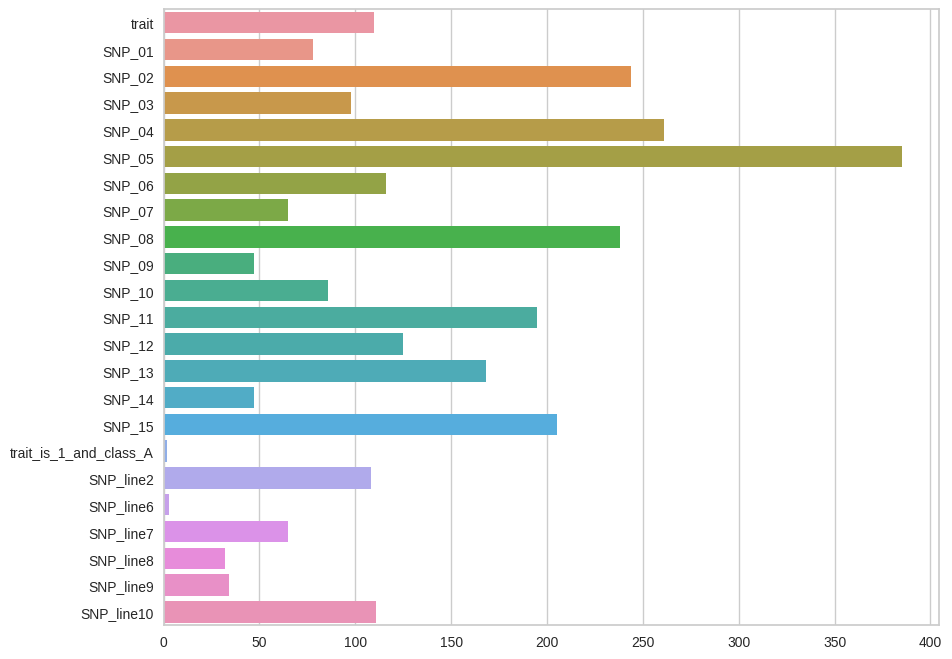

In [1501]:
lgbm = LGBMClassifier()
# lgbm.fit(X_resampled, y_resampled)
lgbm.fit(train_x, train_y)
f = lgbm.feature_importances_
# ft_importance = pd.Series(f, index = .drop(['class'], axis= 1).columns)
ft_importance = pd.Series(f, index = train_x.columns)
# ft_importance = ft_importance.sort_values(ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x = ft_importance, y = train_x.columns)
plt.show()


## Using AUTO ML 

In [1502]:
from pycaret.classification import *
# train = pd.concat([X_resampled, pd.DataFrame({'class':y_resampled})], axis=1)
setup_clf = setup(data=pd.concat([train_x, pd.DataFrame({'class':train_y})], axis=1), target='class', silent=True, session_id = CFG.SEED)
# setup_clf = setup(data=train, target='class', silent=True, session_id = CFG.SEED)

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(262, 24)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,23
8,Ordinal Features,False
9,High Cardinality Features,False


In [1503]:
best_model = compare_models(sort = 'F1', n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9401,0.9815,0.9412,0.9436,0.9398,0.9064,0.9086,0.0090
rf,Random Forest Classifier,0.9401,0.9829,0.9362,0.9440,0.9389,0.9056,0.9087,0.0520
et,Extra Trees Classifier,0.9345,0.9882,0.9320,0.9368,0.9340,0.8975,0.8992,0.0450
lda,Linear Discriminant Analysis,0.9292,0.9886,0.9333,0.9345,0.9292,0.8901,0.8929,0.0060
lightgbm,Light Gradient Boosting Machine,0.9181,0.9780,0.9225,0.9242,0.9179,0.8724,0.8760,0.0160
xgboost,Extreme Gradient Boosting,0.9184,0.9850,0.9205,0.9248,0.9178,0.8728,0.8766,0.0400
ridge,Ridge Classifier,0.9187,0.0000,0.9186,0.9221,0.9177,0.8726,0.8754,0.0040
knn,K Neighbors Classifier,0.9181,0.9696,0.9036,0.9283,0.9137,0.8697,0.8786,0.0100
gbc,Gradient Boosting Classifier,0.9067,0.9793,0.9037,0.9074,0.9052,0.8537,0.8557,0.0420
svm,SVM - Linear Kernel,0.9018,0.0000,0.9036,0.9082,0.9011,0.8469,0.8508,0.0060


In [1504]:
lr = create_model('et', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9912,0.9444,0.9532,0.9465,0.9188,0.9228
1,0.8947,0.9293,0.8963,0.8947,0.8947,0.8348,0.8348
2,0.9474,0.9962,0.9333,0.9526,0.9458,0.9159,0.9202
3,0.8889,0.9853,0.8963,0.8889,0.8889,0.8218,0.8218
4,0.8889,0.9902,0.8917,0.8889,0.8889,0.8286,0.8286
5,0.8889,0.9902,0.8917,0.8889,0.8889,0.8286,0.8286
6,0.9444,1.0000,0.9333,0.9506,0.9430,0.9130,0.9176
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9444,1.0000,0.9333,0.9506,0.9430,0.9130,0.9176


In [1430]:
# tuned_lr = tune_model(lr, fold=10, optimize='F1')
# blended = blend_models(estimator_list=best_model, fold=10, method='hard', optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9687,0.9444,0.9532,0.9465,0.9188,0.9228
1,0.8947,0.9459,0.8963,0.8947,0.8947,0.8348,0.8348
2,0.9474,0.9887,0.9630,0.9561,0.9482,0.9188,0.9228
3,0.8889,0.9416,0.8963,0.8889,0.8889,0.8218,0.8218
4,0.8889,0.9761,0.8917,0.8889,0.8889,0.8286,0.8286
5,0.9444,0.9902,0.9333,0.9506,0.9430,0.9130,0.9176
6,0.9444,0.9915,0.9333,0.9506,0.9430,0.9130,0.9176
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [1431]:
final_model = finalize_model(lr)

# final_model = finalize_model(blended)
preds = predict_model(final_model, data = test_x)

## Data Pre-processing
### Label-Encoding

## Submission

In [1432]:
submit = pd.read_csv('./sample_submission.csv')

In [1433]:
submit['class'] = class_le.inverse_transform(preds['Label'])

In [1434]:
from datetime import datetime
submit.to_csv(f'./answer/submit_{datetime.now()}.csv', index=False)